In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import pandas as pd
import random
from keras.models import load_model

In [ ]:
pip install opencv-python-headless

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Nov 20 00:18:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Keras guide:

https://keras.io/guides/transfer_learning/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_dir = '/content/drive/My Drive/Colab Notebooks/Mestrado final/RXT teste mix_data/'

In [ ]:
tf.io.gfile.listdir(test_dir)

['normais', 'covid', 'tuberculose', 'dip']

In [ ]:
image_shape = (224,224,3)
batch_size = 32

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_gen = ImageDataGenerator()

In [ ]:
image_gen.flow_from_directory(test_dir)

Found 298 images belonging to 4 classes.


In [ ]:
from sklearn.utils import shuffle
test_image_gen = image_gen.flow_from_directory(test_dir,
                                                     #target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=False
                                               )

Found 298 images belonging to 4 classes.


In [ ]:
test_image_gen.class_indices

{'covid': 0, 'dip': 1, 'normais': 2, 'tuberculose': 3}

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Mestrado final/Novos treinamentos/KFolds mix aumentado/VGG19_fine-tuning_RandAugm_avg_4_classes_mix_data_part2345.h5')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 tf.cast (TFOpLambda)        (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem (  (None, None, None, 3)     0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, None, None, 3)     0         
 )                                                               
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928 

In [ ]:
model.evaluate(test_image_gen)

10/10 [==============================] - 44s 4s/step - loss: 0.6880 - accuracy: 0.8826


[0.6880480647087097, 0.8825503587722778]

In [ ]:
pred_probabilities = model.predict(test_image_gen)

10/10 [==============================] - 4s 365ms/step


In [ ]:
def int_predict (pred_probabilities):
  predictions = np.zeros((pred_probabilities.shape[0],1),dtype=int)
  i = 0
  while i < pred_probabilities.shape[0]:
    predictions[i,:] = [np.argmax(pred_probabilities[i])]
    i = i + 1

  return predictions

In [ ]:
predictions = int_predict(pred_probabilities)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
test_image_gen.class_indices

{'covid': 0, 'dip': 1, 'normais': 2, 'tuberculose': 3}

In [ ]:
confusion_matrix(test_image_gen.classes,predictions)

array([[78,  2,  3,  1],
       [ 6, 35,  1,  4],
       [ 3,  2, 76,  3],
       [ 3,  5,  2, 74]])

In [ ]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        84
           1       0.80      0.76      0.78        46
           2       0.93      0.90      0.92        84
           3       0.90      0.88      0.89        84

    accuracy                           0.88       298
   macro avg       0.87      0.87      0.87       298
weighted avg       0.88      0.88      0.88       298



In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [ ]:
y_score = pred_probabilities
num_classes = test_image_gen.num_classes

In [ ]:
# Obtenha as etiquetas verdadeiras de todas as imagens no gerador
y_test = test_image_gen.classes
y_test = label_binarize(y_test, classes=range(num_classes))

In [ ]:
# Calcule as métricas ROC e AUC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

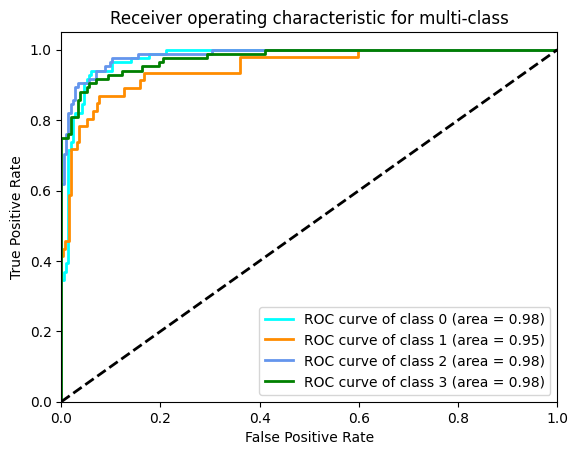

In [ ]:
# Plote a curva ROC para cada classe
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

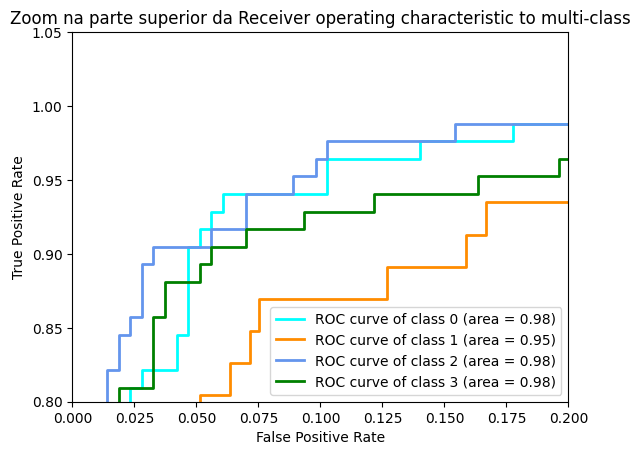

In [ ]:
# Agora, vamos dar zoom em na parte superior esquerda do gráfico.
plt.figure()
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 0.2])  # Ajusta o limite do eixo X para focar no início do gráfico
plt.ylim([0.8, 1.05])  # Ajusta o limite do eixo Y para focar na parte superior do gráfico
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoom na parte superior da Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()